In [2]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os
import math

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from datasets import ExperimentRunner


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [3]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }


def top_k_sparsify(vector, k):
    """Keep top-k absolute values; set the rest to 0."""
    threshold = np.partition(np.abs(vector), -k)[-k]
    sparse_vector = np.where(np.abs(vector) >= threshold, vector, 0)
    return sparse_vector

def sparsify_by_top_k(vector, density):
    """Zero out values to achieve the given density."""
    k = int(len(vector) * density)
    return top_k_sparsify(vector, k)

def sparsify_by_bin_max(vector, density):
    """
    Sparsify the vector by dividing into bins and keeping only the max in each bin.
    
    Parameters:
        vector (np.ndarray): Input dense vector.
        density (float): Fraction of non-zero elements to keep (0 < density <= 1).
        
    Returns:
        np.ndarray: Sparse vector with only one non-zero per bin.
    """
    dim = len(vector)
    n_bins = max(1, int(dim * density))
    bin_size = int(np.ceil(dim / n_bins))

    sparse_vector = np.zeros_like(vector)

    for i in range(n_bins):
        start = i * bin_size
        end = min((i + 1) * bin_size, dim)
        bin_slice = vector[start:end]

        if bin_slice.size > 0:
            max_idx = np.argmax(np.abs(bin_slice))
            sparse_vector[start + max_idx] = bin_slice[max_idx]

    return sparse_vector

def sparsify_by_bin_max_fast(vector, density):
    """
    Efficiently sparsify a vector by binning and keeping only the max (by abs) in each bin.
    
    Parameters:
        vector (np.ndarray): Input dense vector.
        density (float): Fraction of non-zero elements to keep.
    
    Returns:
        np.ndarray: Sparse vector with one non-zero per bin.
    """
    dim = len(vector)
    n_bins = max(1, int(dim * density))
    bin_size = int(np.ceil(dim / n_bins))

    # Pad vector if not divisible by bin_size
    pad_len = (n_bins * bin_size) - dim
    if pad_len > 0:
        vector = np.pad(vector, (0, pad_len), mode='constant')

    # Reshape into bins
    bins = vector.reshape(n_bins, bin_size)

    # Find max indices per bin (by absolute value)
    max_indices = np.argmax(np.abs(bins), axis=1)
    
    # Calculate global indices of max values
    flat_indices = np.arange(n_bins) * bin_size + max_indices

    # Build sparse vector
    sparse_vector = np.zeros_like(vector)
    sparse_vector[flat_indices] = vector[flat_indices]

    # Remove padding if any
    return sparse_vector[:dim]


In [13]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']


g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_right--day_left/gt.mat")

D1    = loadmat("../datasets/descriptors/CMU/20110421/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/CMU/20100901/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

g_truth = loadmat("../datasets/ground_truth/CMU/20110421--20100901/gt.mat")


# D1    = loadmat("../datasets/descriptors/Nordland1000/spring/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/Nordland1000/winter/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

# g_truth = loadmat("../datasets/ground_truth/Nordland1000/spring--winter/gt.mat")


## Visualize

In [14]:
import numpy as np
from dot_product import ScaleQuery


scale_query = ScaleQuery(np.mean(D1,axis=0))
mean_center_D1= scale_query.mean_center_normalize(D1)
norm_D1= scale_query.normalizer.fit_transform(mean_center_D1)

scale_query = ScaleQuery(np.mean(D2,axis=0))
mean_center_D2= scale_query.mean_center_normalize(D2)
norm_D2= scale_query.normalizer.fit_transform(mean_center_D2)


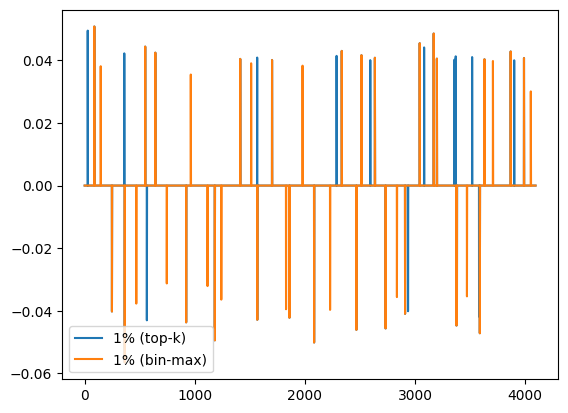

In [15]:
cosines = [np.dot(norm_D1[0], v) for v in norm_D2]
# plt.plot(norm_D1[0], label='original')
plt.plot(sparsify_by_top_k(norm_D1[0], 0.01), label='1% (top-k)')
plt.plot(sparsify_by_bin_max(norm_D1[0], 0.01), label='1% (bin-max)')
plt.legend()
# plt.plot(cosines)
plt.show()

In [16]:
densities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999, 1]
aucs_top_k = []

for density in densities:
    # Sparsify both descriptor sets
    sparse_D1 = np.array([sparsify_by_top_k(d, density) for d in norm_D1])
    sparse_D2 = np.array([sparsify_by_top_k(d, density) for d in norm_D2])
    
    # Calculate cosine similarities
    similarities = np.dot(sparse_D1, sparse_D2.T)
    
    # Calculate AUC
    auc = calculate_evaluation_metrics(-similarities, g_truth)['auc']
    aucs_top_k.append(auc)


In [17]:
aucs_bin_max = []

for density in tqdm(densities, desc="Processing densities"):
    # Sparsify both descriptor sets
    sparse_D1 = np.array([sparsify_by_bin_max_fast(d, density) for d in norm_D1])
    sparse_D2 = np.array([sparsify_by_bin_max_fast(d, density) for d in norm_D2])
    
    # Calculate cosine similarities
    similarities = np.dot(sparse_D1, sparse_D2.T)
    
    # Calculate AUC
    auc = calculate_evaluation_metrics(-similarities, g_truth)['auc']
    aucs_bin_max.append(auc)


Processing densities: 100%|██████████| 15/15 [00:40<00:00,  2.72s/it]


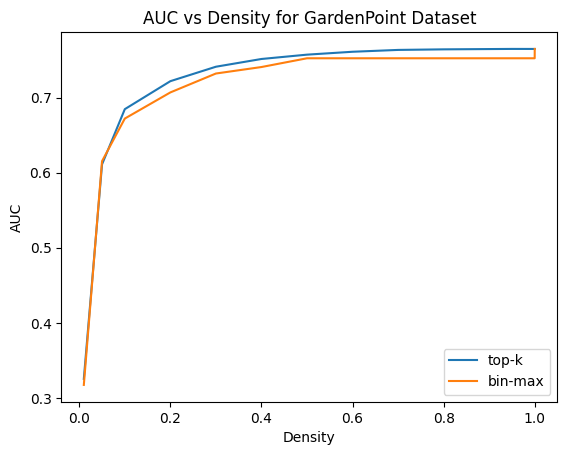

In [18]:
plt.plot(densities, aucs_top_k, label='top-k')
plt.plot(densities, aucs_bin_max, label='bin-max')
plt.title('AUC vs Density for GardenPoint Dataset')
plt.xlabel('Density')
plt.ylabel('AUC')
plt.legend()
plt.show()

## SNN Sparse

In [11]:
from dot_product import  LoihiDotProductSimulationPositive, LoihiDotProductSimulationPositive3Layer, LoihiDotProductSimulationPositiveDBScale, CPUDotProduct


In [8]:
# lets choose p=0.2 and 0.5

constant = 1/math.sqrt(2)

density_low = 0.2
density_high = 0.5

sparse_D1 = np.array([sparsify_by_top_k(d, density_low) for d in D1])
sparse_D2 = np.array([sparsify_by_top_k(d, density_low) for d in D2])

dot = LoihiDotProductSimulationPositiveDBScale(sparse_D1, sparse_D2, constant, timesteps=16, dbScale=6*3)


In [9]:
DD = dot.run(monitor=False)

100%|██████████| 200/200 [00:40<00:00,  4.93it/s]


In [10]:
metrics = calculate_evaluation_metrics(-DD, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.6327356505956265


In [12]:
dot_cp = CPUDotProduct(sparse_D1, sparse_D2)
DD_cpu = dot_cp.run()

metrics = calculate_evaluation_metrics(-DD_cpu, g_truth)
print(f"AUC-CPU: {metrics['auc']}")








AUC-CPU: 0.797165152391355


## SNN 2 Layer

In [5]:


dot = LoihiDotProductSimulationPositiveDBScale(D1, D2, constant, timesteps=16, dbScale=6*3)


In [6]:
# DD, qs, dbs = dot.run()

qs, dbs, monitors = dot.run(monitor=True)

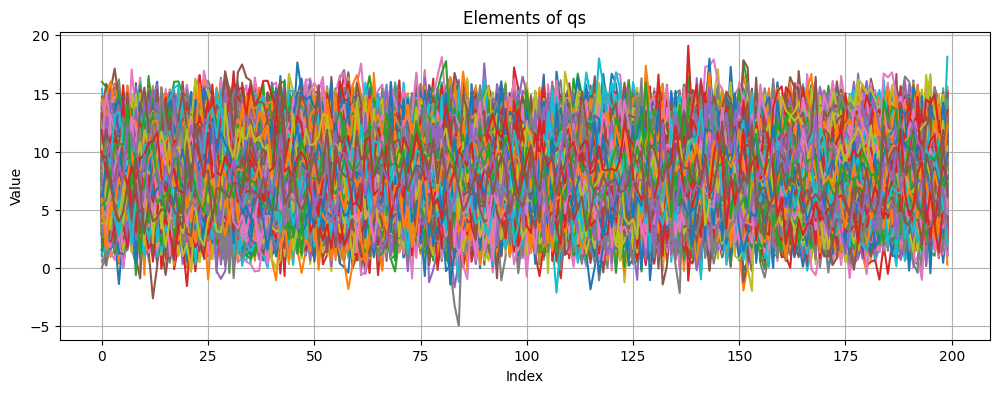

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(qs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of qs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

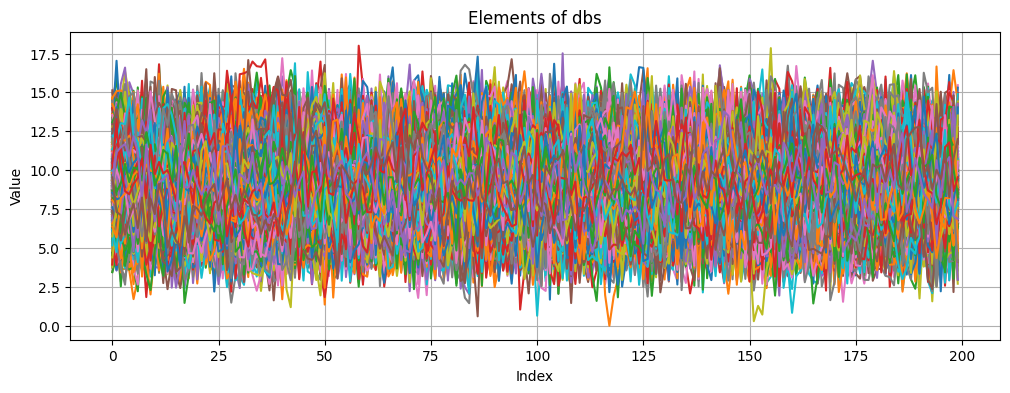

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(dbs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of dbs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

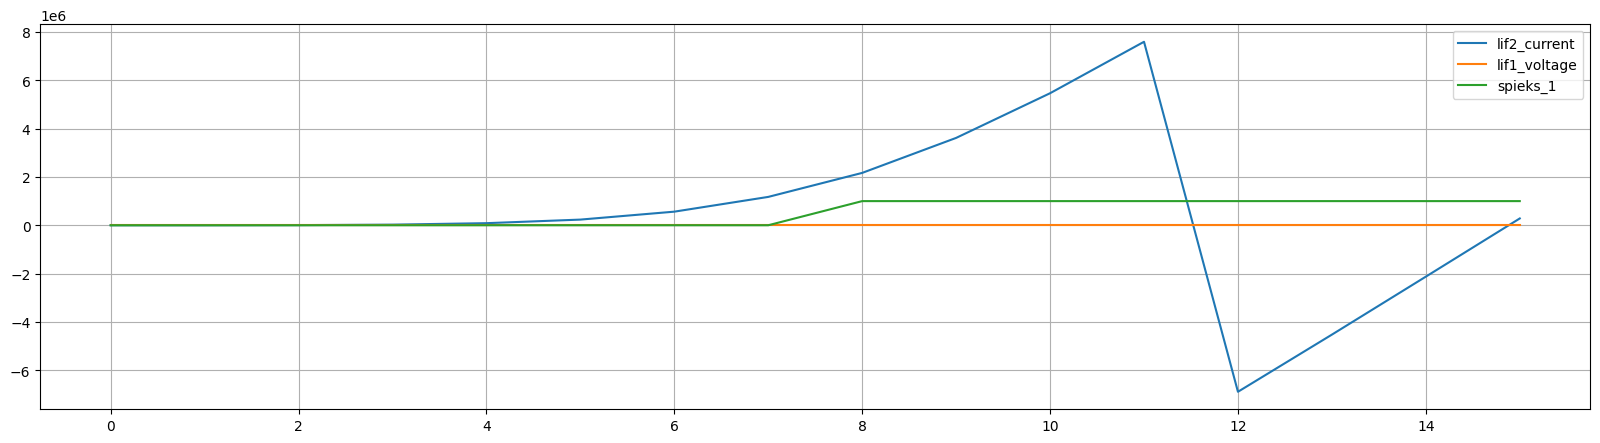

In [9]:
n_id = 150
plt.figure(figsize=(20, 5))
plt.plot(monitors['lif2_current'][:,n_id], label='lif2_current')
plt.plot(monitors['lif1_voltage'][:,n_id], label='lif1_voltage')
plt.plot(monitors['lif1_spikes'][:,n_id] * (10**6), label='spieks_1')
# plt.axhline(y=-(2**16 - 1)*2**6, color='r', linestyle='--', label='vth_lif_2')  # Changed to horizontal line
plt.grid(True)


plt.legend()
plt.show()


In [10]:
DD = dot.run(D1, D2, monitor=False)

100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


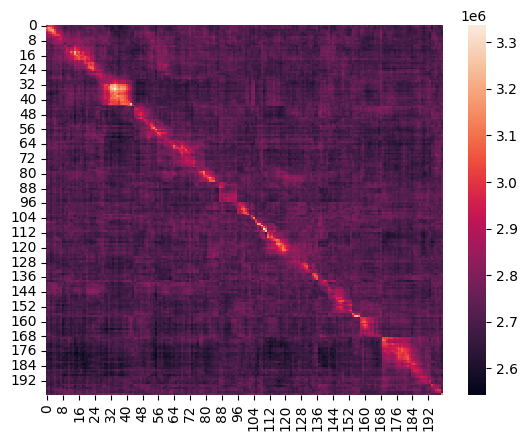

In [11]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [12]:

metrics = calculate_evaluation_metrics(-DD, g_truth)
print(f"AUC: {metrics['auc']}")


AUC: 0.7994890914126087


## Results

In [13]:
# Compute dot product between all pairs of vectors
dot_product_matrix = np.dot(qs, dbs.T)  # This will give a 200x200 matrix

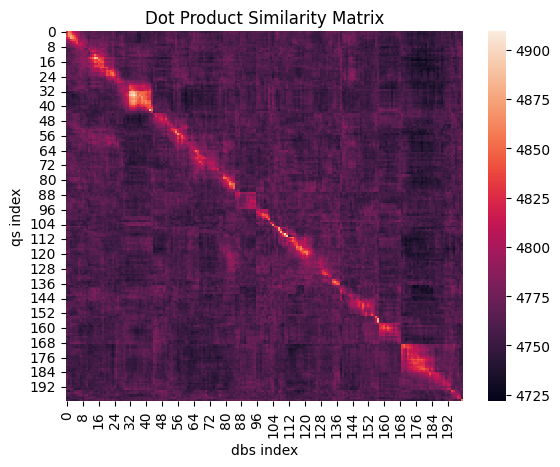

In [14]:
import seaborn as sns

ax = sns.heatmap(dot_product_matrix/2**6)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

In [15]:
metrics = calculate_evaluation_metrics(-dot_product_matrix, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.8177402791460207


In [16]:
0.406751268123599
0.406751268123599
0.406751268123599
0.41105831265952125 # Dense layer multiplied by 10 not timesteps (signs of overflow) -2,000
0.022280486025402297 # Dense layer multiplier changed to 1
0.4147533173640495 # Dense layer multiplied by 20 (signs of overflow) -10,000
# ============================================ Upto this, the constant is 0
0.005699984139190401 # Constant changed to 1/sqrt(2)
0.29100275201856207 # Constant changed to 0 while the vector transformation is done as per positive cpu experiment
0.4528012779410795
0.45785226214439223
0.4634606913087941

0.4634606913087941

In [17]:
hrd =   g_truth['GT']["GThard"][0][0]


In [18]:
sft =   g_truth['GT']["GTsoft"][0][0]

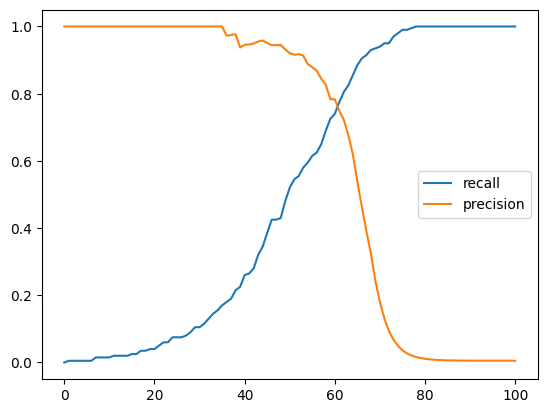

In [19]:
plt.plot(metrics['recall'], label='recall')
plt.plot(metrics['precision'], label='precision')
plt.legend()


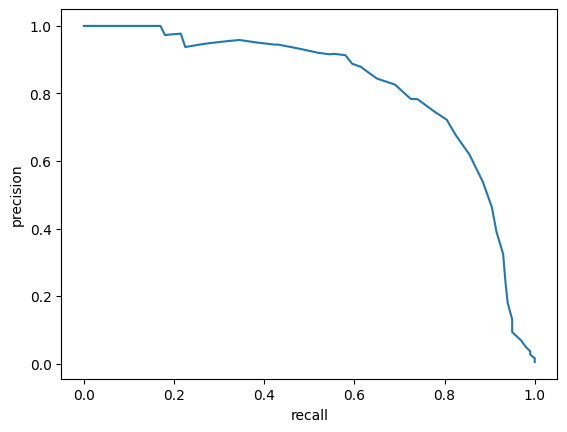

In [20]:

# plt.plot(metrics['precision'], metrics['recall'])
plt.plot(metrics['recall'], metrics['precision'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()




Pivoted DataFrame (wide format for plotting):
p_value                                             1.0       0.5       0.2
cluster_label                                                              
GardensPointWalking - day_left - night_right   0.470215  0.433562  0.440233
GardensPointWalking - day_right - day_left     0.823745  0.816098  0.806918
GardensPointWalking - day_right - night_right  0.758246  0.738711  0.735730
Nordland1000 - spring - summer                 0.622521  0.577314  0.586076
Nordland1000 - spring - winter                 0.746269  0.710678  0.709032
Nordland1000 - summer - fall                   0.852665  0.830052  0.810571
Nordland1000 - summer - winter                 0.412453  0.375663  0.360006
SFUMountain - dry - dusk                       0.709529  0.691608  0.682617
SFUMountain - dry - jan                        0.582108  0.547533  0.537895
SFUMountain - dry - wet                        0.658600  0.620064  0.612279


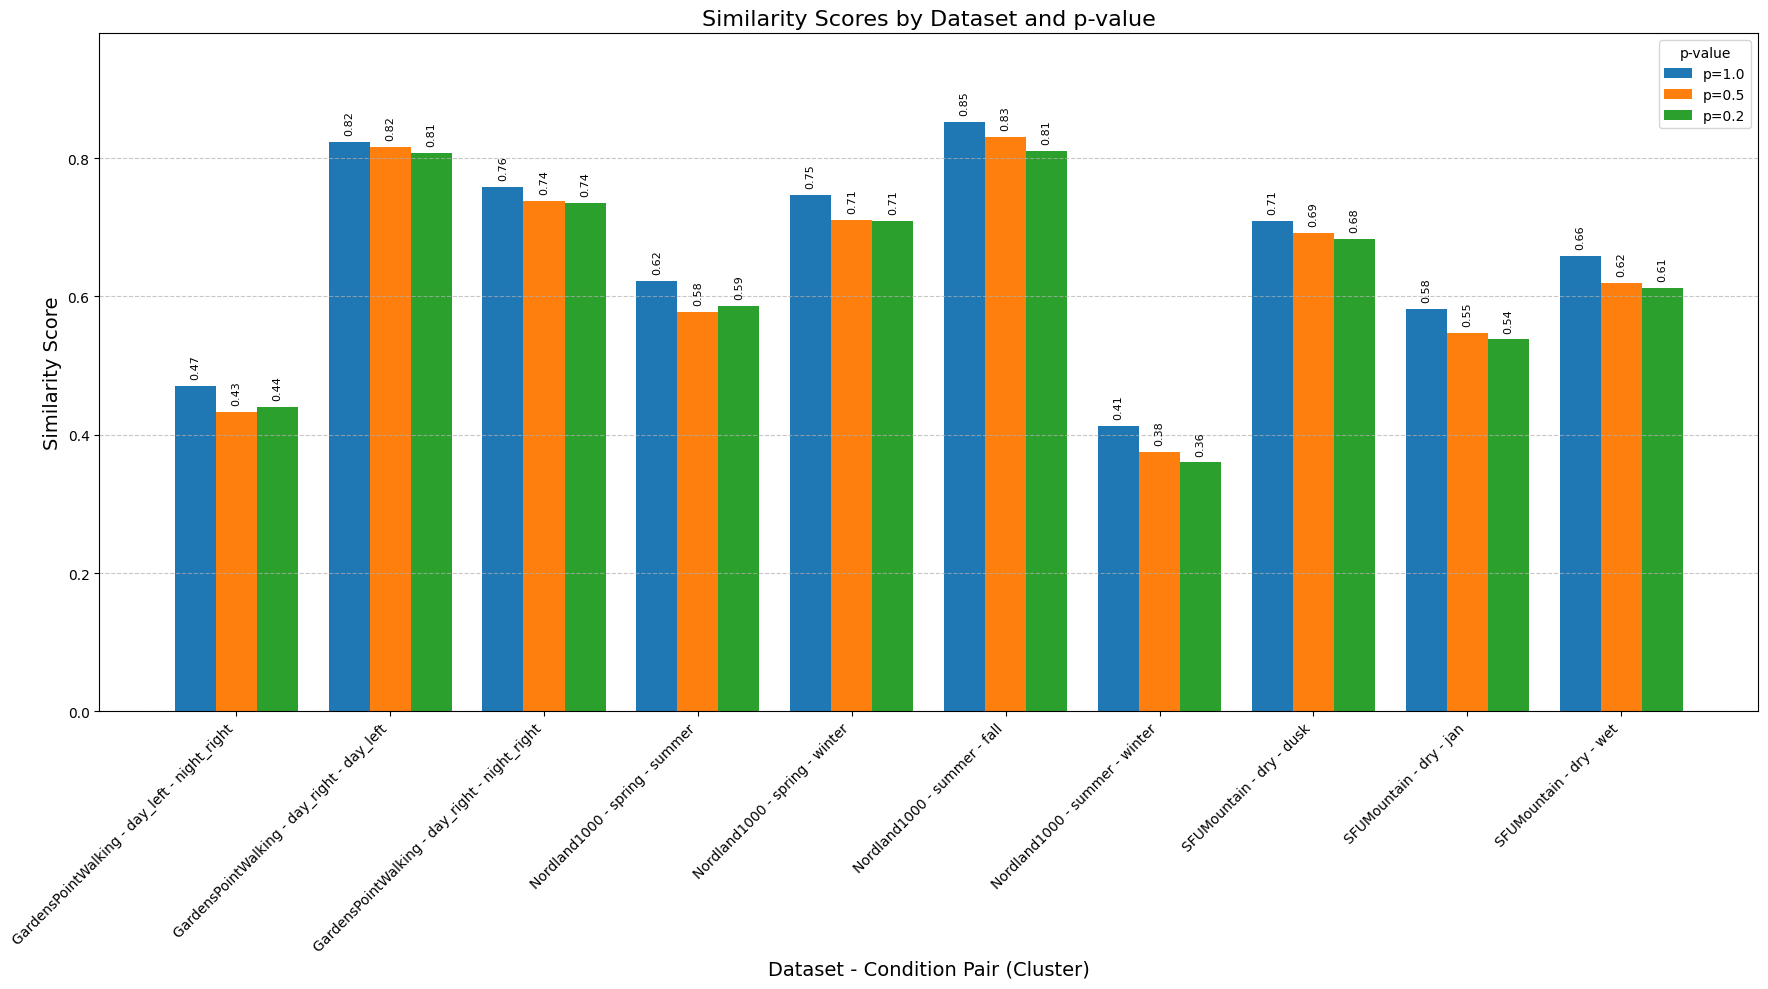

In [13]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_log = """
p=1

========== Evaluating GardensPointWalking ============
Similarity computation time: 0.13 ms
GardensPointWalking - day_left - night_right : 0.4702147082864312 - 0.13 ms - db_size : 200
Similarity computation time: 0.12 ms
GardensPointWalking - day_right - night_right : 0.7582461748985041 - 0.12 ms - db_size : 200
Similarity computation time: 0.08 ms
GardensPointWalking - day_right - day_left : 0.8237447049227817 - 0.08 ms - db_size : 200
========== Evaluating SFUMountain ============
Similarity computation time: 0.09 ms
SFUMountain - dry - dusk : 0.709528570562522 - 0.09 ms - db_size : 385
Similarity computation time: 0.11 ms
SFUMountain - dry - jan : 0.5821075483541491 - 0.11 ms - db_size : 385
Similarity computation time: 0.11 ms
SFUMountain - dry - wet : 0.6585995359444744 - 0.11 ms - db_size : 385
========== Evaluating Nordland1000 ============
Similarity computation time: 0.11 ms
Nordland1000 - spring - winter : 0.7462687790258484 - 0.11 ms - db_size : 1000
Similarity computation time: 0.12 ms
Nordland1000 - spring - summer : 0.6225214390336571 - 0.12 ms - db_size : 1000
Similarity computation time: 0.13 ms
Nordland1000 - summer - winter : 0.41245311014421165 - 0.13 ms - db_size : 1000
Similarity computation time: 0.11 ms
Nordland1000 - summer - fall : 0.8526647063393309 - 0.11 ms - db_size : 1000
========== Evaluating StLucia ============
Similarity computation time: 0.13 ms

p=0.2

========== Evaluating GardensPointWalking ============
Similarity computation time: 0.05 ms
GardensPointWalking - day_left - night_right : 0.44023328088182867 - 0.05 ms - db_size : 200
Similarity computation time: 0.10 ms
GardensPointWalking - day_right - night_right : 0.7357298037841964 - 0.10 ms - db_size : 200
Similarity computation time: 0.06 ms
GardensPointWalking - day_right - day_left : 0.8069183065451175 - 0.06 ms - db_size : 200
========== Evaluating SFUMountain ============
Similarity computation time: 0.09 ms
SFUMountain - dry - dusk : 0.6826172964035346 - 0.09 ms - db_size : 385
Similarity computation time: 0.10 ms
SFUMountain - dry - jan : 0.5378948024735648 - 0.10 ms - db_size : 385
Similarity computation time: 0.10 ms
SFUMountain - dry - wet : 0.6122790278722406 - 0.10 ms - db_size : 385
========== Evaluating Nordland1000 ============
Similarity computation time: 0.11 ms
Nordland1000 - spring - winter : 0.7090321179697826 - 0.11 ms - db_size : 1000
Similarity computation time: 0.12 ms
Nordland1000 - spring - summer : 0.5860755333455911 - 0.12 ms - db_size : 1000
Similarity computation time: 0.10 ms
Nordland1000 - summer - winter : 0.36000592657401903 - 0.10 ms - db_size : 1000
Similarity computation time: 0.10 ms
Nordland1000 - summer - fall : 0.8105705155028025 - 0.10 ms - db_size : 1000
========== Evaluating StLucia ============
Similarity computation time: 0.11 ms

p=0.5

========== Evaluating GardensPointWalking ============
Similarity computation time: 0.08 ms
GardensPointWalking - day_left - night_right : 0.4335618159816037 - 0.08 ms - db_size : 200
Similarity computation time: 0.10 ms
GardensPointWalking - day_right - night_right : 0.7387108924200152 - 0.10 ms - db_size : 200
Similarity computation time: 0.09 ms
GardensPointWalking - day_right - day_left : 0.8160975258614988 - 0.09 ms - db_size : 200
========== Evaluating SFUMountain ============
Similarity computation time: 0.20 ms
SFUMountain - dry - dusk : 0.6916080964283854 - 0.20 ms - db_size : 385
Similarity computation time: 0.17 ms
SFUMountain - dry - jan : 0.5475329838460964 - 0.17 ms - db_size : 385
Similarity computation time: 0.18 ms
SFUMountain - dry - wet : 0.6200637633488832 - 0.18 ms - db_size : 385
========== Evaluating Nordland1000 ============
Similarity computation time: 0.20 ms
Nordland1000 - spring - winter : 0.7106783901410442 - 0.20 ms - db_size : 1000
Similarity computation time: 0.21 ms
Nordland1000 - spring - summer : 0.5773137009890851 - 0.21 ms - db_size : 1000
Similarity computation time: 0.20 ms
Nordland1000 - summer - winter : 0.37566306986915576 - 0.20 ms - db_size : 1000
Similarity computation time: 0.68 ms
Nordland1000 - summer - fall : 0.8300515662223014 - 0.68 ms - db_size : 1000
========== Evaluating StLucia ============
Similarity computation time: 0.78 ms
"""

parsed_data = []
current_p = None

# Regex to capture the label and the score
# Label: "GardensPointWalking - day_left - night_right"
# Score: "0.4702147082864312"
data_line_regex = re.compile(r"^(.*? - .*? - .*?) : (\d+\.\d+) - .*")

for line in data_log.splitlines():
    line = line.strip()
    if not line:
        continue

    if line.startswith("p="):
        current_p = float(line.split("=")[1])
        continue

    match = data_line_regex.match(line)
    if match and current_p is not None:
        label = match.group(1)
        score = float(match.group(2))
        parsed_data.append({
            "p_value": current_p,
            "cluster_label": label,
            "score": score
        })

# Convert to DataFrame
df = pd.DataFrame(parsed_data)

# print("Parsed DataFrame (long format):")
# print(df)

# Pivot the DataFrame to get p_values as columns for clustered bar chart
df_pivot = df.pivot(index="cluster_label", columns="p_value", values="score")

# Ensure the p-value columns are in the desired order for plotting
# The problem statement mentions p=1, 0.5, 0.2. Pandas pivot might sort them (0.2, 0.5, 1.0)
# So let's reorder if necessary.
desired_p_order = [1.0, 0.5, 0.2]
# Filter out any p_values that might not be in the data, and keep existing order if one is missing
actual_p_columns_ordered = [p for p in desired_p_order if p in df_pivot.columns]
if not actual_p_columns_ordered: # If none of the desired p values were found, use existing columns
    actual_p_columns_ordered = df_pivot.columns.tolist()

df_pivot = df_pivot[actual_p_columns_ordered]


print("\nPivoted DataFrame (wide format for plotting):")
print(df_pivot)

# Plotting
num_clusters = len(df_pivot.index)
num_bars_per_cluster = len(df_pivot.columns)
bar_width = 0.8 / num_bars_per_cluster # Adjust bar width based on number of bars per cluster
index = np.arange(num_clusters)

fig, ax = plt.subplots(figsize=(18, 10)) # Increased figure size for readability

for i, p_val in enumerate(df_pivot.columns):
    # Calculate offset for each bar in a cluster
    # The first bar (i=0) is shifted left, middle bars are centered, last bar is shifted right.
    # Total width of bars in a cluster is num_bars_per_cluster * bar_width
    # We want to center this group of bars.
    # Offset for bar 'i' from the center of the group: (i - (num_bars_per_cluster - 1) / 2.0) * bar_width
    offset = (i - (num_bars_per_cluster - 1) / 2.0) * bar_width
    
    bars = ax.bar(index + offset, df_pivot[p_val], bar_width, label=f'p={p_val}')
    
    # Add text labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        if not np.isnan(yval): # Don't plot text for NaN values
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', # Format to 2 decimal places
                    va='bottom', ha='center', fontsize=8, rotation=90)


ax.set_xlabel('Dataset - Condition Pair (Cluster)', fontsize=14)
ax.set_ylabel('Similarity Score', fontsize=14)
ax.set_title('Similarity Scores by Dataset and p-value', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(df_pivot.index, rotation=45, ha="right", fontsize=10)
ax.legend(title='p-value')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, df_pivot.max().max() * 1.15 if not df_pivot.empty else 1) # Set y-limit slightly above max score

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()